# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 01.12.2022

Мягкий дедлайн: 23:59MSK 11.12.2022

Жесткий дедлайн: 23:59MSK 15.12.2022

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
boston = load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

33.41097281327496

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
def compute_bootstrap_index(n_samples):
    """
    :param: n_samples: number of samples in initial data
    :returns: bootstrap_indices, out_of_bag_indices
    """
    boot_indices = np.random.choice(np.arange(n_samples), size=n_samples)

    out_of_bag_mask = np.ones(n_samples, dtype=bool)
    out_of_bag_mask[boot_indices] = False
    out_of_bag_indices = np.arange(n_samples)[out_of_bag_mask]

    return boot_indices, out_of_bag_indices


In [ ]:
def compute_bias_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    y_mean = np.zeros(y.shape)
    y_squares_mean = np.zeros(y.shape)
    y_mse = np.zeros(y.shape)
    y_hits = np.zeros(y.shape)

    for i in range(num_runs):
        boot_indices, oob_indices = compute_bootstrap_index(X.shape[0])

        X_boot, y_boot = X[boot_indices], y[boot_indices]

        regressor.fit(X_boot, y_boot)
        y_predict = regressor.predict(X)

        y_mean[oob_indices] += y_predict[oob_indices]
        y_squares_mean[oob_indices] += np.power(y_predict[oob_indices], 2)
        y_mse[oob_indices] += np.power(y_predict[oob_indices] - y[oob_indices], 2)
        y_hits[oob_indices] += 1

    y_mean /= y_hits
    y_squares_mean /= y_hits
    y_mse /= y_hits

    y_bias = np.power(y_mean - y, 2)
    y_var = y_squares_mean - np.power(y_mean, 2)

    bias = np.mean(y_bias)
    variance = np.mean(y_var)
    error = np.mean(y_mse)

    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

In [ ]:
model_lr = LinearRegression()
model_dt = DecisionTreeRegressor()
model_rf = RandomForestRegressor()

lr_bve = compute_bias_variance(model_lr, X, y)
print(f'LinearRegression:\nBias = {lr_bve[0]}, Variance = {lr_bve[1]}, Error = {lr_bve[2]}')

dt_bve = compute_bias_variance(model_dt, X, y)
print(f'DecisionTreeRegressor:\nBias = {dt_bve[0]}, Variance = {dt_bve[1]}, Error = {dt_bve[2]}')

rf_bve = compute_bias_variance(model_rf, X, y)
print(f'RandomForestRegressor:\nBias = {rf_bve[0]}, Variance = {rf_bve[1]}, Error = {rf_bve[2]}')

LinearRegression:
Bias = 23.732592167663903, Variance = 0.931847495762515, Error = 24.664439663426414
DecisionTreeRegressor:
Bias = 10.319194636307557, Variance = 13.253740322483123, Error = 23.572934958790633
RandomForestRegressor:
Bias = 10.632855303306986, Variance = 2.2501193091813474, Error = 12.882974612488404


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

Мы ожидаемо получили высокое смещение у модели линейной регрессии, в сравнении с деревьями, яро подстраивающимися под данные. С разбросом всё тоже соответствует нашим предположениям - у одного дерева он высокий, модель очень чувствительна к данным. Проблему решает RandomForest, однако разброса линейной модели деревья так и не достигают. С нашим предположением о том, что RF не меняет смещение и сокращает разброс всё так же сходится. Он работает намнооого дольше, но зато засчёт бутстрапа понижает коррелированность базовых моделей - разброс упал в 6 раз из 10 возможных! Если оценивать качетво модели по подсчитанной ошибке, то перформит в 2 раза лучше, успех!

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

В теории если базовые модели некоррелированы, то бэггинг уменьшает разброс в n_estimators = 10 раз. Понятно, что наш случай неидеален - для деревьев смогли уменьшить разброс в 4 раза, линейная регрессия вообще чуточку ухудшилась, а бэггинг над рандом форестом (прокачанным бэггингом) - что-то странное. По итогу, сравнивая бэггинг над деревьями с RF, получили что второй в 1.5 раза лучше с точки зрения уменьшения разброса.

In [ ]:
from sklearn.ensemble import BaggingRegressor

In [ ]:
model_bagging_lr = BaggingRegressor(LinearRegression())
model_bagging_dt = BaggingRegressor(DecisionTreeRegressor())
model_bagging_rf = BaggingRegressor(RandomForestRegressor())

bagging_lr_bve = compute_bias_variance(model_bagging_lr, X, y)
print(f'LinearRegression with bagging:\n \
    Bias = {bagging_lr_bve[0]}, Variance = {bagging_lr_bve[1]}, Error = {bagging_lr_bve[2]}')

bagging_dt_bve = compute_bias_variance(model_bagging_dt, X, y)
print(f'DecisionTreeRegressor with bagging:\n \
    Bias = {bagging_dt_bve[0]}, Variance = {bagging_dt_bve[1]}, Error = {bagging_dt_bve[2]}')

bagging_rf_bve = compute_bias_variance(model_bagging_rf, X, y)
print(f'RandomForestRegressor with bagging:\n \
    Bias = {bagging_rf_bve[0]}, Variance = {bagging_rf_bve[1]}, Error = {bagging_rf_bve[2]}')

LinearRegression with bagging:
     Bias = 23.713788584501863, Variance = 1.0091430800699364, Error = 24.722931664571746
DecisionTreeRegressor with bagging:
     Bias = 10.605871305205856, Variance = 3.347968110010543, Error = 13.95383941521636
RandomForestRegressor with bagging:
     Bias = 11.71621779595789, Variance = 1.431898894868622, Error = 13.148116690826456


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def plot_predictions(regressors, X, y, num_runs=100, num_test_objects=10, titles=[]):
    """
    plot graphics described above
    """
    test_indices = np.random.choice(np.arange(X.shape[0]), size=num_test_objects, replace=False)
    train_mask = np.ones(X.shape[0], dtype=bool)
    train_mask[test_indices] = False

    X_train, y_train = X[train_mask], y[train_mask]
    X_test, y_test = X[test_indices], y[test_indices]

    fig, axes = plt.subplots(nrows=1, ncols=len(regressors), figsize=(20, 5))

    for i in range(num_runs):
        boot_indices, oob_indices = compute_bootstrap_index(X_train.shape[0])
        X_boot, y_boot = X_train[boot_indices], y_train[boot_indices]

        for j, regressor in enumerate(regressors):
            regressor.fit(X_boot, y_boot)
            y_test_predict = regressor.predict(X_test)
            axes[j].scatter(x=np.arange(num_test_objects), y=y_test_predict, color='pink')
            if titles:
                axes[j].set_title(titles[j])

    for j in range(len(regressors)):
        axes[j].scatter(x=np.arange(num_test_objects), y=y_test, color='black')
        axes[j].set_xlabel('Test indices')
        axes[j].set_ylabel('Target predictions and true')
        axes[j].set_xticks(range(num_test_objects))

    plt.show()

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

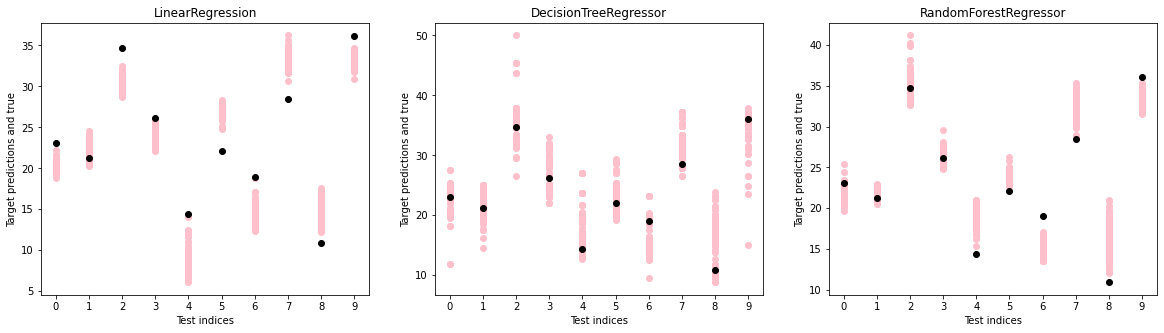

In [ ]:
regressors = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
titles = ["LinearRegression", "DecisionTreeRegressor", "RandomForestRegressor"]
plot_predictions(regressors, X, y, titles=titles)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__

Линейная Регрессия достаточно кучкуется, но всё же далека от правды (низкий разброс, высокое смещение, всё по фэн-шую)

Деревья лучше попадают, но зато заметна низкая плотность предсказаний - то высокий разброс, подсказывают нам макаки гор Эмэйшань (откуда они взялись, почему мы вообще здесь?). Кажется, наши дальние кровные собраться решились объяснять толкования духов bias-variance-decomposition для нас, так же, как обучать буддистких монахов многие столетия тому назад. Но это лишь широкий взгляд на происходящее, несвойственный нам, людям. Нам лучше делать домашки по мо и слушать бебезян. 

Рандомный Лес завораживает наши мысли тихим шелестом - это спокойствие разброса, непоколебимость модели в сочетании с высокой точностью предсказаний. Какой-то мудрый человек соорудил скамью с видом на этот шелест, теперь мы можем слиться с ним на несколько минут свободы духа.

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
max_depth_grid = np.arange(1, 11)
biases, variances = [], []

for max_depth in max_depth_grid:
    regressor = DecisionTreeRegressor(max_depth=max_depth)
    bias, variance, mse = compute_bias_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)

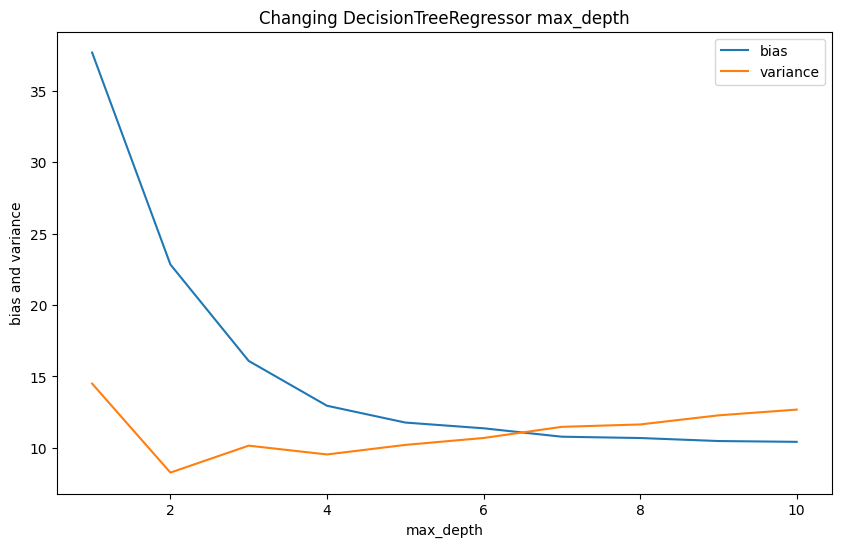

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(max_depth_grid, biases)
plt.plot(max_depth_grid, variances)
plt.title('Changing DecisionTreeRegressor max_depth')
plt.xlabel('max_depth')
plt.ylabel('bias and variance')
plt.legend(['bias', 'variance'])
plt.show()

In [ ]:
max_features_grid = np.arange(1, X.shape[1] + 1)
biases, variances = [], []

for max_features in max_features_grid:
    regressor = DecisionTreeRegressor(max_features=max_features)
    bias, variance, mse = compute_bias_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)

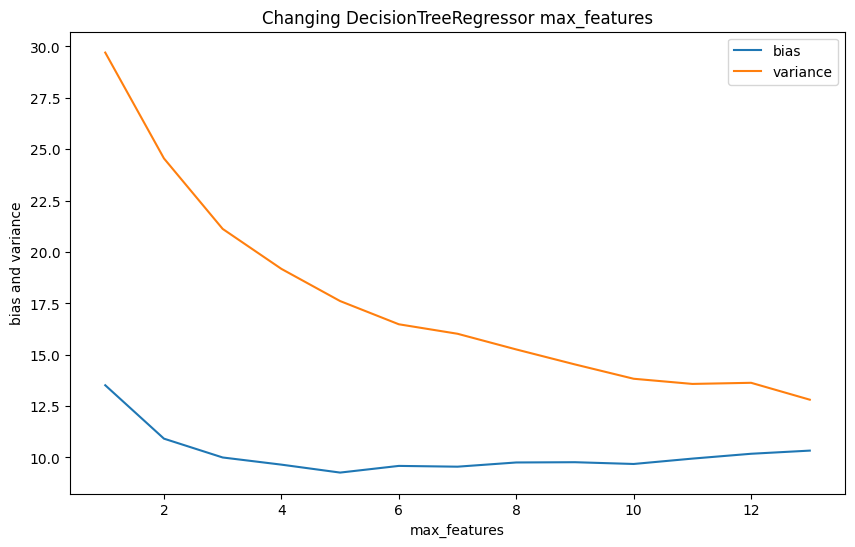

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(max_features_grid, biases)
plt.plot(max_features_grid, variances)
plt.title('Changing DecisionTreeRegressor max_features')
plt.xlabel('max_features')
plt.ylabel('bias and variance')
plt.legend(['bias', 'variance'])
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
n_estimators_grid = np.power(2, np.arange(1, 10))
biases, variances = [], []

for n_estimators in n_estimators_grid:
    regressor = RandomForestRegressor(n_estimators=n_estimators)
    bias, variance, mse = compute_bias_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)

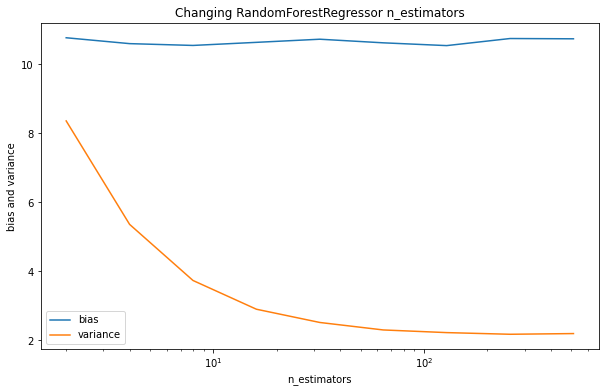

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(n_estimators_grid, biases)
plt.plot(n_estimators_grid, variances)
plt.title('Changing RandomForestRegressor n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('bias and variance')
plt.legend(['bias', 'variance'])
plt.xscale('log')
plt.show()

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
n_estimators_grid = np.power(2, np.arange(1, 10))
biases, variances = [], []

for n_estimators in n_estimators_grid:
    regressor = GradientBoostingRegressor(n_estimators=n_estimators)
    bias, variance, mse = compute_bias_variance(regressor, X, y)
    biases.append(bias)
    variances.append(variance)

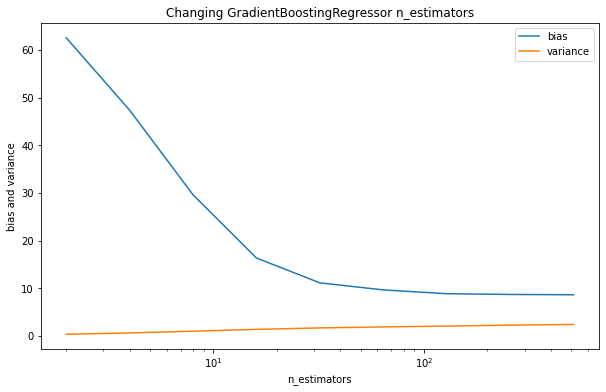

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
plt.plot(n_estimators_grid, biases)
plt.plot(n_estimators_grid, variances)
plt.title('Changing GradientBoostingRegressor n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('bias and variance')
plt.legend(['bias', 'variance'])
plt.xscale('log')
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

Глубина одиночных деревьев улучшает смещение, но нам открывается та самая плата за точность - подрастающий разброс. Ещё духи говорят нам не ограничивать max_features, чересчур увеличивающий разброс при малых своих значениях. Да и оптимальное смещение где-то на средних значениях гиперпараметра.

Но вот оно, снова... Ты чувствуешь шелест? Целый Рандомный Лес успокаивает бушующий разброс, бебзяны указывают нам на силу бутстрапированных выборок и объединения рандомизированных деревьев. Чем больше деревьев, тем спокойнее душе, тем чище воздух и умиротворённее наши шаги. Причём даже на логарифмической шкале разброс успокаивается с экспоненциальной зависимостью от n_estimators... Смещение же непоколебимо, ведь деревья не изменить.

Но вот мы уже покачиваясь просыпаемся, вокруг плывут сотни каноэ и слышится шёпот австронезийских языков. Где мы, что мы, зачем мы? Мы - свидетели на пути прогресса, ведь вместе деревья улучшили друг друга, это - градиентный бустинг - творение, олицетворённое в деревянных каноэ. Каждый раз, когда сильные руки новогвинейца ровняют (оптимизируют) эти лодки, их смещение значительно падает и стремиться к 10 - значению глубоких, добротных деревьев. Так лодки всё точнее и точнее плывут к ещё не открытым островам. Разброс же изначально крайне мал, каноэ плывут в гармонии с тихим, неглубоким океаном. Но всё же разброс стабильно подрастает, пока наши новые друзья-австронезийцы стремятся к всё более далёким островам.





__11. Бонус (0.1 балла)__


Прикрепите фотографию того, как вы начали эту зиму ❄️

__Your answer here:__

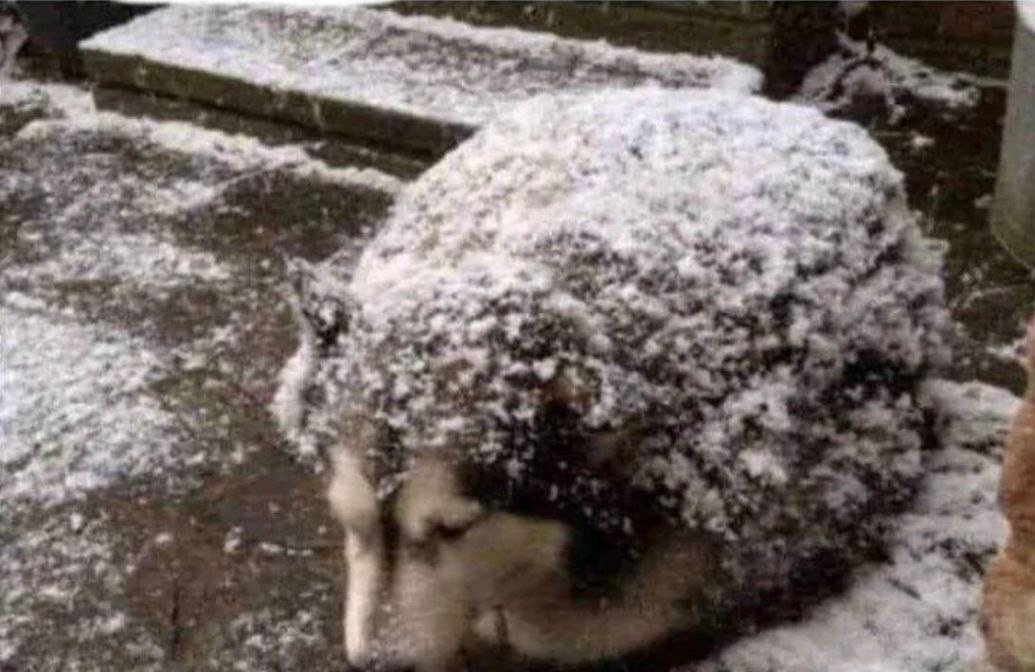

зимний я пон.

Всё, что мы помним с 6-го путешествия (пожалуй, стоило выпить таблетки для памяти раньше):

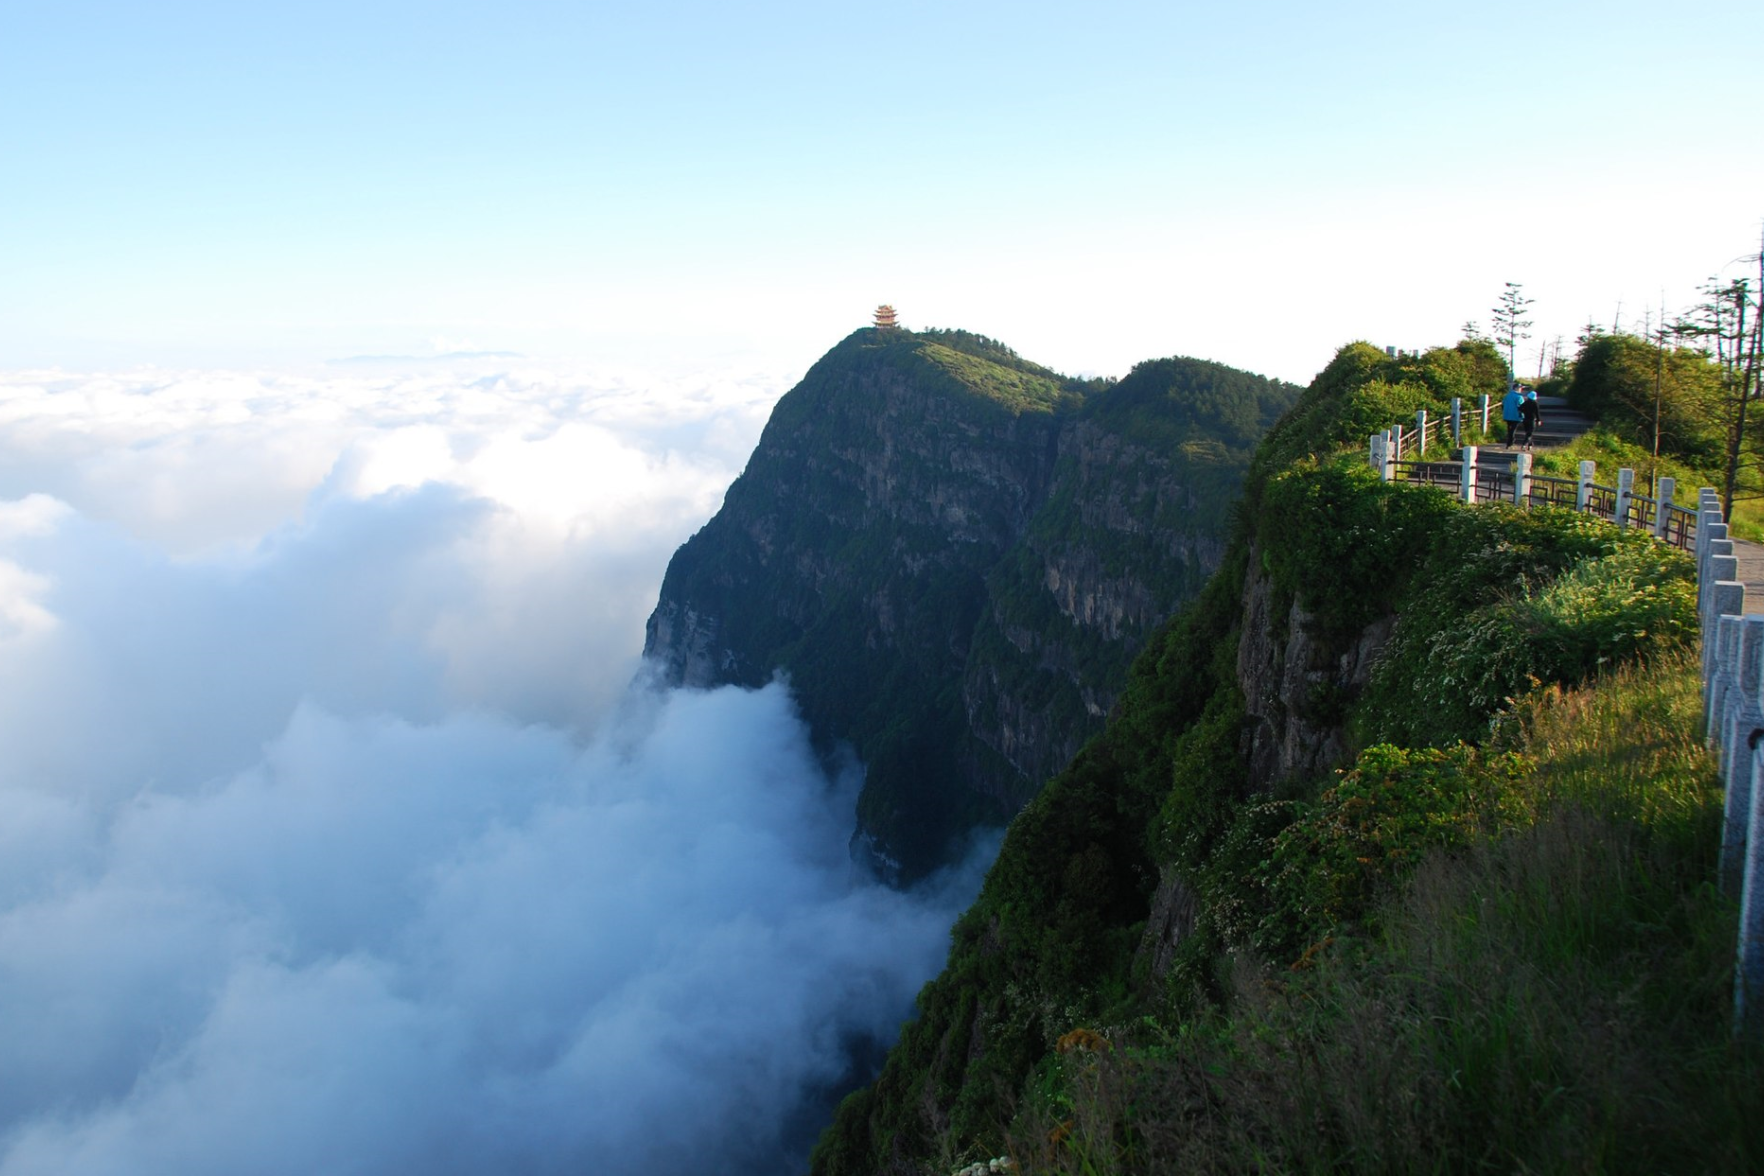



Всезнающие горы.

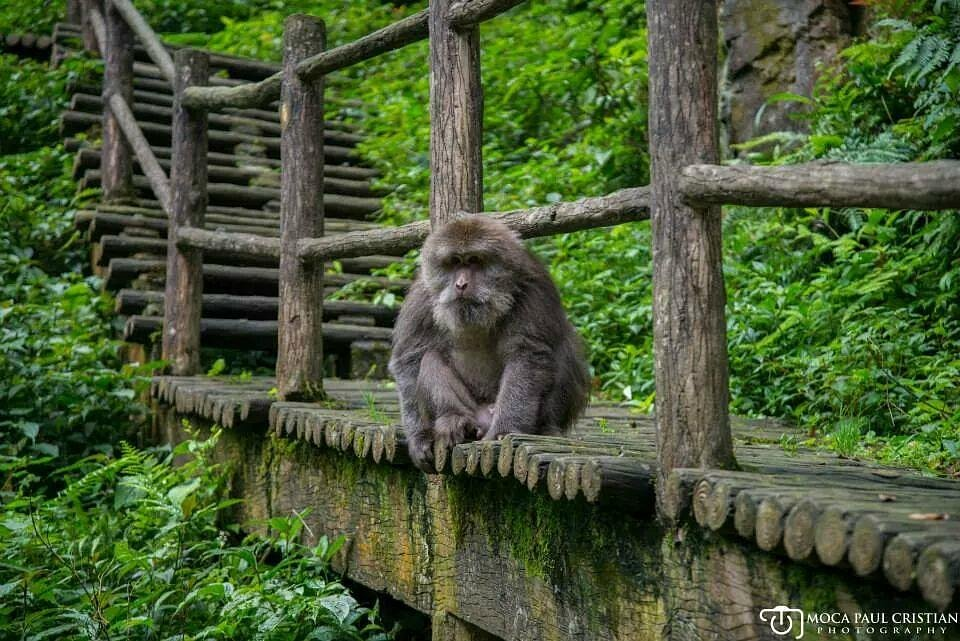

Мудрец, передававший нам знания духов

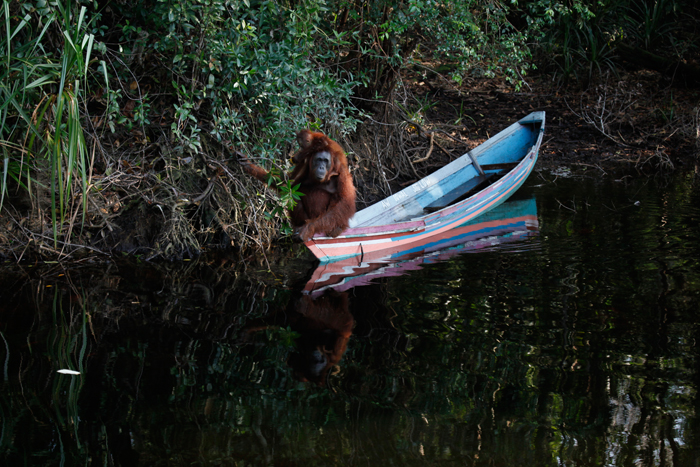

Ещё один мудрец, он помогал нам переселяться с новогвинейцами, пока мы спали непробудным сном.

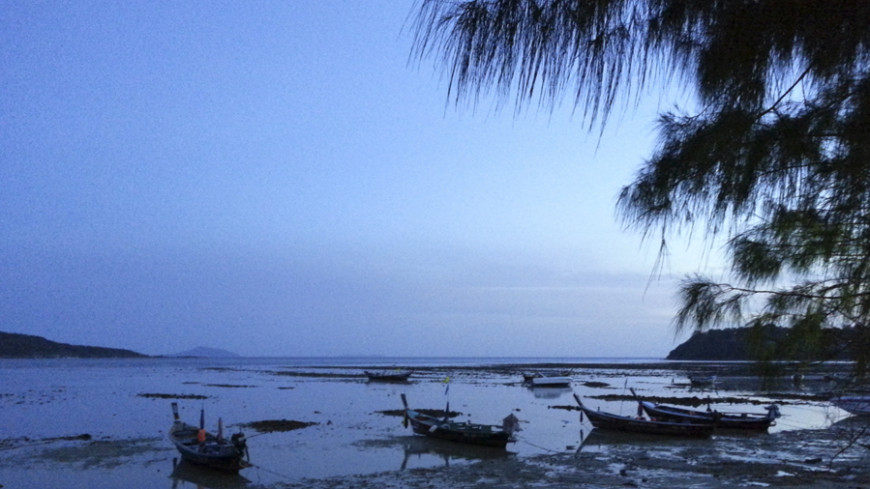

Последнее, что мы помним, за десять минут до нашего нового, чистого островного сна.